In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import _pickle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time
import os
import peakutils

from ourfunctions_v3 import clean_nan_samples, remove_noise

In [2]:
path = "D:/GitHub/Machine-Learning/Kaggle/"
savepath = path + 'Kaggle classifiers/low area/'
path_results = path + 'Kaggle_results/'

ncpu = os.cpu_count()
if (ncpu>2): njobs = ncpu - 2; 
else: njobs = 1;
    
zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
df_train = _pickle.loads(zf.open('TrainData.pkl').read())
zf.close()

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read())
zf.close()

df_train = remove_noise(df_train)

# Extract data (spectra) and targets of the df_train set
data = df_train.iloc[:,-2:]
targets = df_train.iloc[:,1:-2]

# Then, split into a train and test_train set
data_train, data_test_train, targets_train, targets_test_train = train_test_split(data, targets, test_size=0.3, random_state=11) # split the data
print('Training samples: '+str(len(data_train))+' and test_train samples: ' + str(len(data_test_train)) )

Training sample 339  eliminated
Training sample 490  eliminated
Training samples: 359 and test_train samples: 155


## Full spectrum with low area magnification
The idea is to perform the usual "spectrum_in_bins" but with two modifications:
* Magnify the low area (2000-4000), by normalizing it by its own constant
* Enable bin_size smaller than 1 (hyperresolution)

In [3]:
def spectrum_in_bins_lowareamagnification(df,m,middle,M,bin_size_lowarea,bin_size):
    # Lowarea
    range_min_lowarea = []; range_max_lowarea = []; range_mean_lowarea = []
    for mz in np.arange(m,middle,bin_size_lowarea):
        range_min_lowarea.append(mz)
        range_max_lowarea.append(mz+bin_size_lowarea)
        range_mean_lowarea.append(np.mean([range_min_lowarea[-1],range_max_lowarea[-1]]))

    N = len(df)  # number of samples
    L = len(range_min_lowarea)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((L,))
        for i,mz in enumerate(range_min_lowarea):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size_lowarea))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[i] = np.interp(x=range_mean_lowarea[i],xp=mzcoord,fp=intensity)

        # Remove baseline
        idx_data_in_bins -= peakutils.baseline(idx_data_in_bins,deg=4)
        # Normalize the amplitude of the spectrum
        idx_data_in_bins = idx_data_in_bins / np.max(idx_data_in_bins)
        # Store in matrix
        all_data[idx,:] = idx_data_in_bins.reshape(1, -1)
    new_df_lowarea = pd.DataFrame(data=all_data, columns = range_mean_lowarea, index = df.index)    
    print('Low area finished')


    # High area    
    range_min = []; range_max = []; range_mean = []
    for mz in np.arange(middle,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_mean.append(np.mean([range_min[-1],range_max[-1]]))

    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((L,))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)

        # Remove baseline
        idx_data_in_bins -= peakutils.baseline(idx_data_in_bins,deg=4)
        # Normalize the amplitude of the spectrum
        idx_data_in_bins = idx_data_in_bins / np.max(idx_data_in_bins)
        # Store in matrix
        all_data[idx,:] = idx_data_in_bins.reshape(1, -1)
    new_df = pd.DataFrame(data=all_data, columns = range_mean, index = df.index)
    print('High area finished')

    merged_spectrum = pd.concat([new_df_lowarea,new_df],axis=1)
    print('DONE!')
    return merged_spectrum

In [4]:
def spectrum_in_bins_5(df, m, M, bin_size): # allows binsize < 1
    
    range_min = []; range_max = []; range_mean = []
    for mz in np.arange(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_mean.append(np.mean([range_min[-1],range_max[-1]]))
    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[0,i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)

        # Remove baseline
        idx_data_in_bins[0,:] -= peakutils.baseline(idx_data_in_bins[0,:],deg=4)
        # Normalize the amplitude of the spectrum
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / np.max(idx_data_in_bins[0,:])
        # Store in matrix
        all_data[idx,:] = idx_data_in_bins
    new_df = pd.DataFrame(data=all_data, columns = range_mean, index = df.index)
    print('DONE!')
    return new_df

In [5]:
def try_clf(clf, params, spectrum_train, targets_train, n_cv=5, njobs=5,
            FEATURE_SELECTION=False, feature_vector_list=None):  
    # new version --> Incorporates feature selection
    t1 = time.time()

    best_classifiers = []
    grid_list = []
    AUC_train = []; AUC_valid = []

    categories = targets_train.columns[:]
    for c, cat in enumerate(categories):

        print([cat])  # indicate in which antibiotic we are

        # Selection of train and test data (depending on whether there are NaN target values)
        X_train, Y_train = clean_nan_samples(spectrum_train, targets_train, c, cat)

        if FEATURE_SELECTION:  # a boolean that decides whether to apply feature selection
            # (feature list has to be already defined, and input to the function)
            X_train = apply_feature_selection(X_train, feature_vector_list[c])

        # perform a GridSearchCV in order to train a classifier for this antibiotic
        grid = GridSearchCV(clf, param_grid=params, scoring='roc_auc', n_jobs=njobs, 
                            pre_dispatch='2*n_jobs', cv=n_cv, return_train_score=True)
        grid.fit(X_train, Y_train)

        # print the best parameters (to detect edge values), and save that classifier
        print('The best parameters are: ', grid.best_params_)
        best_clf = grid.best_estimator_
        best_classifiers.append(best_clf)
        grid_list.append(grid)

        best_clf = np.where(grid.cv_results_['rank_test_score'] == 1)[0][0]
        AUC_train.append(grid.cv_results_['mean_train_score'][best_clf])
        AUC_valid.append(grid.cv_results_['mean_test_score'][best_clf])

        print('Train AUC: ', np.round(AUC_train[-1], 4), ' and validation AUC: ', np.round(AUC_valid[-1], 4))

    avg_AUC_train = np.mean(AUC_train)
    avg_AUC_valid = np.mean(AUC_valid)
    print('\n\nThe average train AUC is', np.round(avg_AUC_train, 4), 'and the avg validation AUC is',
          np.round(avg_AUC_valid, 4))

    t2 = time.time()
    print('\nFull execution took ', np.round(t2 - t1, 1), 'seconds')
    print('\nDONE!')
    return best_classifiers, grid_list, AUC_train, AUC_valid

In [13]:
def get_test_score(clf_list, spectrum_test, targets_test):
    AUC_test = []
    categories = targets_test.columns[:]
    for c, cat in enumerate(categories):
        X_test, Y_test = clean_nan_samples(spectrum_test, targets_test, c, cat)
        pred = clf_list[c].predict_proba(X_test)[:,1]
        AUC_test.append(roc_auc_score(Y_test, pred))
    return AUC_test

## Redefine functions for faster performance

In [10]:
def spectrum_in_bins_6(df, m, M, bin_size): # allows binsize < 1
    
    range_min = []; range_max = []; range_mean = []
    for mz in np.arange(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_mean.append(np.mean([range_min[-1],range_max[-1]]))
    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        interpolated_spectrum = np.interp(x=range_mean,xp=mzcoord,fp=intensity)
        idx_data_in_bins = np.zeros((L,))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[i] = interpolated_spectrum[i]

        # Remove baseline
        idx_data_in_bins -= peakutils.baseline(idx_data_in_bins,deg=4)
        # Normalize the amplitude of the spectrum
        idx_data_in_bins = idx_data_in_bins / np.max(idx_data_in_bins)
        # Store in matrix
        all_data[idx,:] = idx_data_in_bins.reshape(1,-1)
    new_df = pd.DataFrame(data=all_data, columns = range_mean, index = df.index)
    print('DONE!')
    return new_df

In [12]:
bin_size = 0.5

t1 = time.time()
spectrum_test_train_normal05 = spectrum_in_bins_6(data_test_train,m,M,bin_size)
t2 = time.time()
print('New method:',(t2-t1))
spectrum_test_train_normal05 = spectrum_in_bins_5(data_test_train,m,M,bin_size)
t3 = time.time()
print('Old method:',(t3-t2))

DONE!
New method: 74.0294828414917
DONE!
Old method: 81.85581159591675


# Tengo que revisar esto, y timear la funccion. Es muy raro que tarde tantísimo.

## Trials
Let's make many different trials with different parameters for the binning.
Let's try normal (all normalized by same constant) and with low area magnification, both until 4.000 and 5.000.
Let's try binsizes of 5, 2 , 1 , 0.5, 0.2, 0.1
Additionally, let's try larger binsize to lowarea, to avoid noise. Let's first try that, and apply it to the rest.

In [7]:
m = 2000
middle = 4000
M = 12500
bin_size = 0.5
bin_size_lowarea = 0.5

spectrum_train_magnif05 = spectrum_in_bins_lowareamagnification(data_train,m,middle,M,bin_size_lowarea,bin_size)
spectrum_test_train_magnif05 = spectrum_in_bins_lowareamagnification(data_test_train,m,middle,M,bin_size_lowarea,bin_size)
spectrum_train_normal05 = spectrum_in_bins_5(data_train,m,M,bin_size)
spectrum_test_train_normal05 = spectrum_in_bins_5(data_test_train,m,M,bin_size)

Low area finished
High area finished
DONE!
Low area finished
High area finished
DONE!
DONE!
DONE!


In [14]:
from sklearn.svm import SVC
clf = SVC(class_weight='balanced', probability=True,kernel='linear')
params = {'C':[0.05,0.1,0.5,1,5,10]}

In [15]:
clf_list_magnif05, grid_list, AUC_train_magnif05, AUC_valid_magnif05 = try_clf(clf, params, spectrum_train_magnif05, targets_train)
AUC_test_magnif05 = get_test_score(clf_list_magnif05, spectrum_test_train_magnif05, targets_test_train)

['OXACILINA']
The best parameters are:  {'C': 1}
Train AUC:  0.9809  and validation AUC:  0.8719
['AMIKACINA']
The best parameters are:  {'C': 1}
Train AUC:  0.9918  and validation AUC:  0.7963
['AMOXI/CLAV']
The best parameters are:  {'C': 1}
Train AUC:  0.9818  and validation AUC:  0.8592
['CIPROFLOXACINO']
The best parameters are:  {'C': 1}
Train AUC:  0.982  and validation AUC:  0.8566
['CLINDAMICINA']
The best parameters are:  {'C': 0.05}
Train AUC:  0.8457  and validation AUC:  0.6968
['ERITROMICINA']
The best parameters are:  {'C': 1}
Train AUC:  0.9756  and validation AUC:  0.757
['LEVOFLOXACINO']
The best parameters are:  {'C': 0.5}
Train AUC:  0.9772  and validation AUC:  0.8511
['PENICILINA']
The best parameters are:  {'C': 1}
Train AUC:  0.9967  and validation AUC:  0.7364
['TOBRAMICINA']
The best parameters are:  {'C': 0.5}
Train AUC:  0.9823  and validation AUC:  0.8161


The average train AUC is 0.9682 and the avg validation AUC is 0.8046

Full execution took  684.7 seco

In [27]:
print(np.mean(AUC_test_magnif05))

0.763859306169464


In [16]:
spectrum_train_magnif405 = spectrum_in_bins_lowareamagnification(data_train,m,middle,M,4,bin_size)
spectrum_test_train_magnif405 = spectrum_in_bins_lowareamagnification(data_test_train,m,middle,M,4,bin_size)

clf_list_magnif405, grid_list, AUC_train_magnif405, AUC_valid_magnif405 = try_clf(clf, params, spectrum_train_magnif405, targets_train)
AUC_test_magnif405 = get_test_score(clf_list_magnif405, spectrum_test_train_magnif405, targets_test_train)

Low area finished
High area finished
DONE!
Low area finished
High area finished
DONE!
['OXACILINA']
The best parameters are:  {'C': 1}
Train AUC:  0.9517  and validation AUC:  0.8662
['AMIKACINA']
The best parameters are:  {'C': 1}
Train AUC:  0.9699  and validation AUC:  0.8014
['AMOXI/CLAV']
The best parameters are:  {'C': 5}
Train AUC:  0.989  and validation AUC:  0.8567
['CIPROFLOXACINO']
The best parameters are:  {'C': 1}
Train AUC:  0.9583  and validation AUC:  0.8429
['CLINDAMICINA']
The best parameters are:  {'C': 0.1}
Train AUC:  0.8286  and validation AUC:  0.7068
['ERITROMICINA']
The best parameters are:  {'C': 10}
Train AUC:  0.993  and validation AUC:  0.7568
['LEVOFLOXACINO']
The best parameters are:  {'C': 5}
Train AUC:  0.9937  and validation AUC:  0.8272
['PENICILINA']
The best parameters are:  {'C': 1}
Train AUC:  0.9827  and validation AUC:  0.7344
['TOBRAMICINA']
The best parameters are:  {'C': 1}
Train AUC:  0.9737  and validation AUC:  0.8206


The average train A

In [28]:
print(np.mean(AUC_test_magnif405))

0.7601462284159424


In [17]:
clf_list_normal05, grid_list, AUC_train_normal05, AUC_valid_normal05 = try_clf(clf, params, spectrum_train_normal05, targets_train)
AUC_test_normal05 = get_test_score(clf_list_normal05, spectrum_test_train_normal05, targets_test_train)

['OXACILINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9817  and validation AUC:  0.8611
['AMIKACINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9926  and validation AUC:  0.8098
['AMOXI/CLAV']
The best parameters are:  {'C': 5}
Train AUC:  0.9801  and validation AUC:  0.8596
['CIPROFLOXACINO']
The best parameters are:  {'C': 1}
Train AUC:  0.9466  and validation AUC:  0.843
['CLINDAMICINA']
The best parameters are:  {'C': 0.05}
Train AUC:  0.7905  and validation AUC:  0.7073
['ERITROMICINA']
The best parameters are:  {'C': 1}
Train AUC:  0.9183  and validation AUC:  0.762
['LEVOFLOXACINO']
The best parameters are:  {'C': 5}
Train AUC:  0.9832  and validation AUC:  0.8349
['PENICILINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9942  and validation AUC:  0.727
['TOBRAMICINA']
The best parameters are:  {'C': 0.5}
Train AUC:  0.9369  and validation AUC:  0.8139


The average train AUC is 0.9471 and the avg validation AUC is 0.8021

Full execution took  685.6 seconds

In [29]:
print(np.mean(AUC_test_normal05))

0.7732770560548778


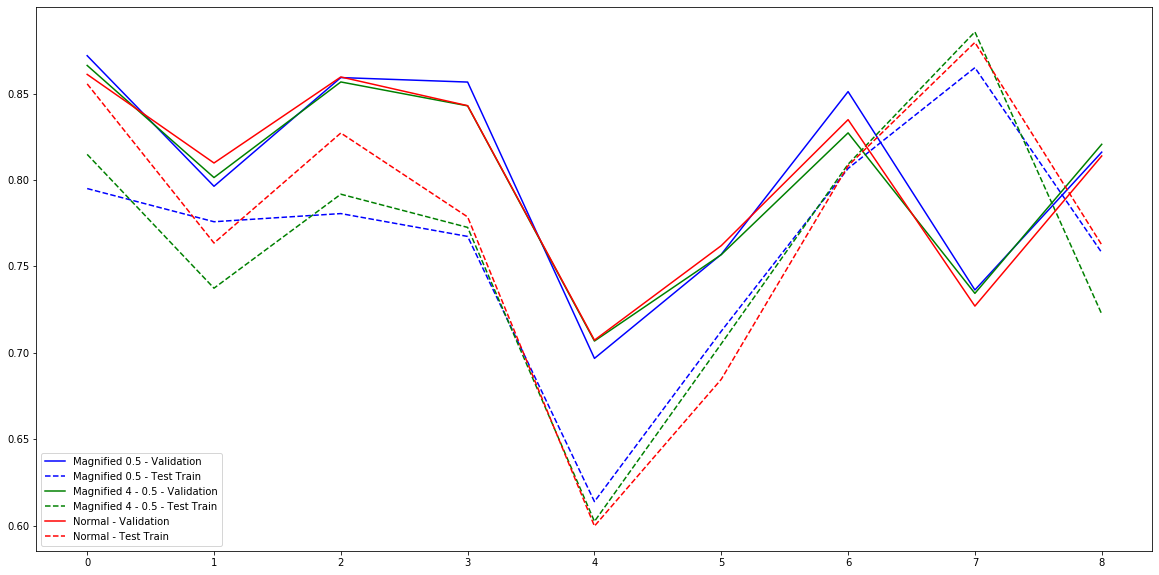

In [23]:
plt.figure(figsize=(20,10))
plt.plot(AUC_valid_magnif05,'b',label='Magnified 0.5 - Validation')
plt.plot(AUC_test_magnif05,'b--',label='Magnified 0.5 - Test Train')
plt.plot(AUC_valid_magnif405,'g',label='Magnified 4 - 0.5 - Validation')
plt.plot(AUC_test_magnif405,'g--',label='Magnified 4 - 0.5 - Test Train')
plt.plot(AUC_valid_normal05,'r',label='Normal - Validation')
plt.plot(AUC_test_normal05,'r--',label='Normal - Test Train')
plt.legend(); plt.show()

Bin size más grande en low area lo empeora, así que no voy a seguir usandolo. Eso sí, voy a meter hasta 5000.

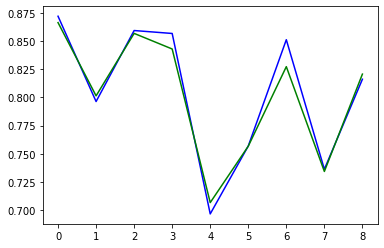

In [24]:
plt.plot(AUC_valid_magnif05,'b',label='Magnified 0.5 - Validation')
plt.plot(AUC_valid_magnif405,'g',label='Magnified 4 - 0.5 - Validation')

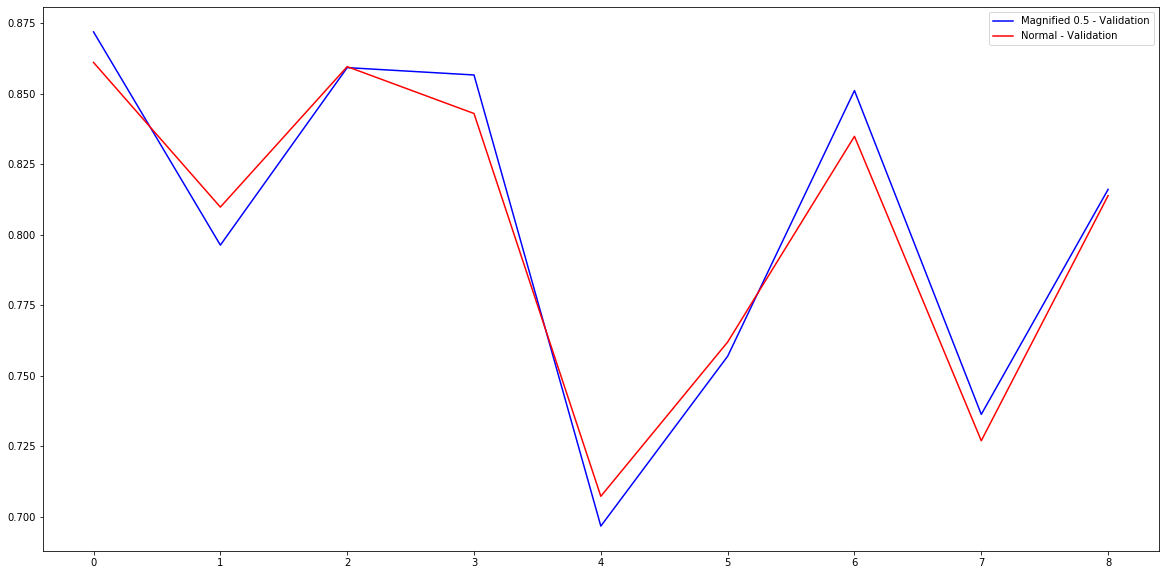

In [25]:
plt.figure(figsize=(20,10))
plt.plot(AUC_valid_magnif05,'b',label='Magnified 0.5 - Validation')
plt.plot(AUC_valid_normal05,'r',label='Normal - Validation')
plt.legend(); plt.show()

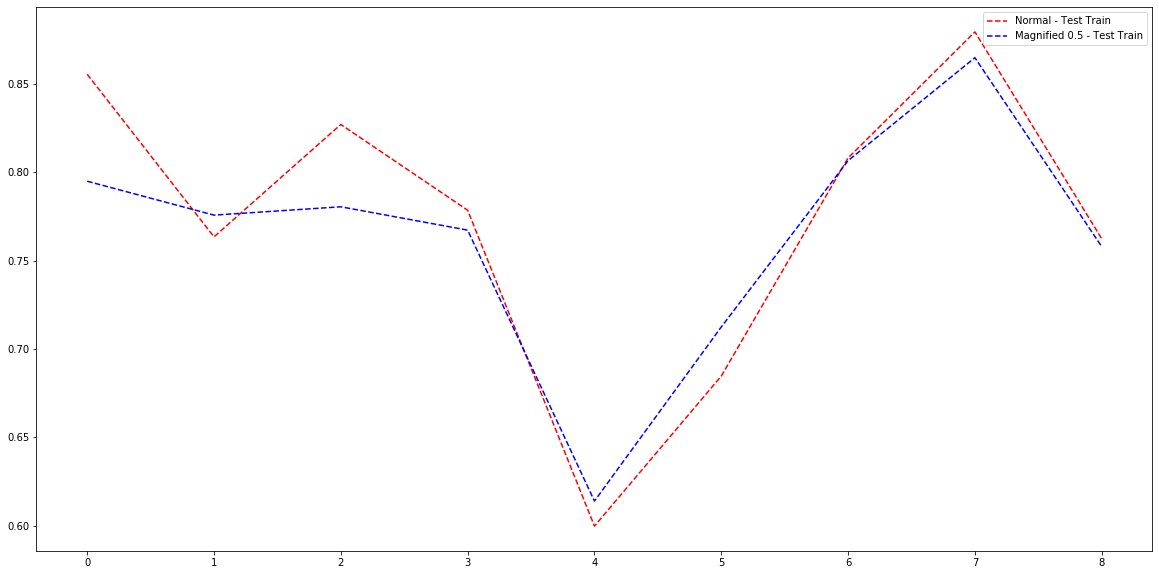

In [26]:
plt.figure(figsize=(20,10))
plt.plot(AUC_test_normal05,'r--',label='Normal - Test Train')
plt.plot(AUC_test_magnif05,'b--',label='Magnified 0.5 - Test Train')
plt.legend(); plt.show()

Parece que depende bastante de la feature. Voy a seguir probando con las dos. Ahora con otros binsize, para ver como influye.

#### bin size 5

In [30]:
bin_size = 5
bin_size_lowarea = 5
middle = 5000

spectrum_train_magnif5 = spectrum_in_bins_lowareamagnification(data_train,m,middle,M,bin_size_lowarea,bin_size)
spectrum_test_train_magnif5 = spectrum_in_bins_lowareamagnification(data_test_train,m,middle,M,bin_size_lowarea,bin_size)
spectrum_train_normal5 = spectrum_in_bins_5(data_train,m,M,bin_size)
spectrum_test_train_normal5 = spectrum_in_bins_5(data_test_train,m,M,bin_size)

Low area finished
High area finished
DONE!
Low area finished
High area finished
DONE!
DONE!
DONE!


In [31]:
clf_list_normal5, grid_list, AUC_train_normal5, AUC_valid_normal5 = try_clf(clf, params, spectrum_train_normal5, targets_train)
AUC_test_normal5 = get_test_score(clf_list_normal5, spectrum_test_train_normal5, targets_test_train)

['OXACILINA']
The best parameters are:  {'C': 10}
Train AUC:  0.937  and validation AUC:  0.8322
['AMIKACINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9593  and validation AUC:  0.7847
['AMOXI/CLAV']
The best parameters are:  {'C': 10}
Train AUC:  0.939  and validation AUC:  0.8304
['CIPROFLOXACINO']
The best parameters are:  {'C': 5}
Train AUC:  0.9297  and validation AUC:  0.8406
['CLINDAMICINA']
The best parameters are:  {'C': 1}
Train AUC:  0.8283  and validation AUC:  0.7175
['ERITROMICINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9174  and validation AUC:  0.7382
['LEVOFLOXACINO']
The best parameters are:  {'C': 10}
Train AUC:  0.9523  and validation AUC:  0.8208
['PENICILINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9722  and validation AUC:  0.7042
['TOBRAMICINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9559  and validation AUC:  0.8024


The average train AUC is 0.9323 and the avg validation AUC is 0.7857

Full execution took  73.4 secon

In [32]:
clf_list_magnif5, grid_list, AUC_train_magnif5, AUC_valid_magnif5 = try_clf(clf, params, spectrum_train_magnif5, targets_train)
AUC_test_magnif5 = get_test_score(clf_list_magnif5, spectrum_test_train_magnif5, targets_test_train)

['OXACILINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9575  and validation AUC:  0.8411
['AMIKACINA']
The best parameters are:  {'C': 5}
Train AUC:  0.957  and validation AUC:  0.7849
['AMOXI/CLAV']
The best parameters are:  {'C': 10}
Train AUC:  0.9584  and validation AUC:  0.8341
['CIPROFLOXACINO']
The best parameters are:  {'C': 5}
Train AUC:  0.9525  and validation AUC:  0.8285
['CLINDAMICINA']
The best parameters are:  {'C': 1}
Train AUC:  0.845  and validation AUC:  0.6872
['ERITROMICINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9386  and validation AUC:  0.7396
['LEVOFLOXACINO']
The best parameters are:  {'C': 5}
Train AUC:  0.957  and validation AUC:  0.8324
['PENICILINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9884  and validation AUC:  0.716
['TOBRAMICINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9547  and validation AUC:  0.796


The average train AUC is 0.9454 and the avg validation AUC is 0.7844

Full execution took  69.4 seconds

DO

#### bin size 2

In [33]:
bin_size = 2
bin_size_lowarea = 2
middle = 5000

spectrum_train_magnif2 = spectrum_in_bins_lowareamagnification(data_train,m,middle,M,bin_size_lowarea,bin_size)
spectrum_test_train_magnif2 = spectrum_in_bins_lowareamagnification(data_test_train,m,middle,M,bin_size_lowarea,bin_size)
spectrum_train_normal2 = spectrum_in_bins_5(data_train,m,M,bin_size)
spectrum_test_train_normal2 = spectrum_in_bins_5(data_test_train,m,M,bin_size)

Low area finished
High area finished
DONE!
Low area finished
High area finished
DONE!
DONE!
DONE!


In [34]:
clf_list_normal2, grid_list, AUC_train_normal2, AUC_valid_normal2 = try_clf(clf, params, spectrum_train_normal2, targets_train)
AUC_test_normal2 = get_test_score(clf_list_normal2, spectrum_test_train_normal2, targets_test_train)

['OXACILINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9624  and validation AUC:  0.8557
['AMIKACINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9832  and validation AUC:  0.7998
['AMOXI/CLAV']
The best parameters are:  {'C': 10}
Train AUC:  0.966  and validation AUC:  0.8469
['CIPROFLOXACINO']
The best parameters are:  {'C': 5}
Train AUC:  0.9499  and validation AUC:  0.8415
['CLINDAMICINA']
The best parameters are:  {'C': 0.5}
Train AUC:  0.828  and validation AUC:  0.7072
['ERITROMICINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9272  and validation AUC:  0.7612
['LEVOFLOXACINO']
The best parameters are:  {'C': 10}
Train AUC:  0.9719  and validation AUC:  0.8419
['PENICILINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9862  and validation AUC:  0.741
['TOBRAMICINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9837  and validation AUC:  0.8091


The average train AUC is 0.951 and the avg validation AUC is 0.8005

Full execution took  189.5 secon

In [35]:
clf_list_magnif2, grid_list, AUC_train_magnif2, AUC_valid_magnif2 = try_clf(clf, params, spectrum_train_magnif2, targets_train)
AUC_test_magnif2 = get_test_score(clf_list_magnif2, spectrum_test_train_magnif2, targets_test_train)

['OXACILINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9818  and validation AUC:  0.8639
['AMIKACINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9909  and validation AUC:  0.8251
['AMOXI/CLAV']
The best parameters are:  {'C': 10}
Train AUC:  0.9827  and validation AUC:  0.8515
['CIPROFLOXACINO']
The best parameters are:  {'C': 5}
Train AUC:  0.9683  and validation AUC:  0.843
['CLINDAMICINA']
The best parameters are:  {'C': 0.5}
Train AUC:  0.8478  and validation AUC:  0.6841
['ERITROMICINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9469  and validation AUC:  0.7398
['LEVOFLOXACINO']
The best parameters are:  {'C': 1}
Train AUC:  0.946  and validation AUC:  0.8382
['PENICILINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9903  and validation AUC:  0.7399
['TOBRAMICINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9797  and validation AUC:  0.8309


The average train AUC is 0.9594 and the avg validation AUC is 0.8018

Full execution took  184.0 second

#### bin size 1

In [36]:
bin_size = 1
bin_size_lowarea = 1
middle = 5000

spectrum_train_magnif1 = spectrum_in_bins_lowareamagnification(data_train,m,middle,M,bin_size_lowarea,bin_size)
spectrum_test_train_magnif1 = spectrum_in_bins_lowareamagnification(data_test_train,m,middle,M,bin_size_lowarea,bin_size)
spectrum_train_normal1 = spectrum_in_bins_5(data_train,m,M,bin_size)
spectrum_test_train_normal1 = spectrum_in_bins_5(data_test_train,m,M,bin_size)

Low area finished
High area finished
DONE!
Low area finished
High area finished
DONE!
DONE!
DONE!


In [37]:
clf_list_normal1, grid_list, AUC_train_normal1, AUC_valid_normal1 = try_clf(clf, params, spectrum_train_normal1, targets_train)
AUC_test_normal1 = get_test_score(clf_list_normal1, spectrum_test_train_normal1, targets_test_train)

['OXACILINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9825  and validation AUC:  0.8599
['AMIKACINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9838  and validation AUC:  0.8094
['AMOXI/CLAV']
The best parameters are:  {'C': 10}
Train AUC:  0.9818  and validation AUC:  0.858
['CIPROFLOXACINO']
The best parameters are:  {'C': 5}
Train AUC:  0.9646  and validation AUC:  0.8446
['CLINDAMICINA']
The best parameters are:  {'C': 0.5}
Train AUC:  0.8587  and validation AUC:  0.7079
['ERITROMICINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9505  and validation AUC:  0.7631
['LEVOFLOXACINO']
The best parameters are:  {'C': 5}
Train AUC:  0.9708  and validation AUC:  0.843
['PENICILINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9877  and validation AUC:  0.7352
['TOBRAMICINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9846  and validation AUC:  0.815


The average train AUC is 0.9628 and the avg validation AUC is 0.804

Full execution took  351.3 seconds



In [38]:
clf_list_magnif1, grid_list, AUC_train_magnif1, AUC_valid_magnif1 = try_clf(clf, params, spectrum_train_magnif1, targets_train)
AUC_test_magnif1 = get_test_score(clf_list_magnif1, spectrum_test_train_magnif1, targets_test_train)

['OXACILINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9904  and validation AUC:  0.8724
['AMIKACINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9909  and validation AUC:  0.8302
['AMOXI/CLAV']
The best parameters are:  {'C': 10}
Train AUC:  0.9915  and validation AUC:  0.8584
['CIPROFLOXACINO']
The best parameters are:  {'C': 1}
Train AUC:  0.9553  and validation AUC:  0.847
['CLINDAMICINA']
The best parameters are:  {'C': 0.05}
Train AUC:  0.7779  and validation AUC:  0.6741
['ERITROMICINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9885  and validation AUC:  0.7476
['LEVOFLOXACINO']
The best parameters are:  {'C': 0.5}
Train AUC:  0.947  and validation AUC:  0.8466
['PENICILINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9946  and validation AUC:  0.734
['TOBRAMICINA']
The best parameters are:  {'C': 1}
Train AUC:  0.9548  and validation AUC:  0.8336


The average train AUC is 0.9545 and the avg validation AUC is 0.8049

Full execution took  342.1 seco

#### bin size 0.1 --> lets go hard!!

In [42]:
bin_size = 0.1
bin_size_lowarea = 0.1
middle = 5000

spectrum_train_magnif01 = spectrum_in_bins_lowareamagnification(data_train,m,middle,M,bin_size_lowarea,bin_size)
spectrum_test_train_magnif01 = spectrum_in_bins_lowareamagnification(data_test_train,m,middle,M,bin_size_lowarea,bin_size)
spectrum_train_normal01 = spectrum_in_bins_5(data_train,m,M,bin_size)
spectrum_test_train_normal01 = spectrum_in_bins_5(data_test_train,m,M,bin_size)

Low area finished
High area finished
DONE!
Low area finished
High area finished
DONE!
DONE!
DONE!


In [43]:
clf_list_normal01, grid_list, AUC_train_normal01, AUC_valid_normal01 = try_clf(clf, params, spectrum_train_normal01, targets_train)
AUC_test_normal01 = get_test_score(clf_list_normal01, spectrum_test_train_normal01, targets_test_train)

['OXACILINA']


KeyboardInterrupt: 

In [ ]:
clf_list_magnif01, grid_list, AUC_train_magnif01, AUC_valid_magnif01 = try_clf(clf, params, spectrum_train_magnif01, targets_train)
AUC_test_magnif01 = get_test_score(clf_list_magnif01, spectrum_test_train_magnif01, targets_test_train)

#### bin size 15 --> other direction

In [44]:
bin_size = 15
bin_size_lowarea = 15
middle = 5000

spectrum_train_magnif15 = spectrum_in_bins_lowareamagnification(data_train,m,middle,M,bin_size_lowarea,bin_size)
spectrum_test_train_magnif15 = spectrum_in_bins_lowareamagnification(data_test_train,m,middle,M,bin_size_lowarea,bin_size)
spectrum_train_normal15 = spectrum_in_bins_5(data_train,m,M,bin_size)
spectrum_test_train_normal15 = spectrum_in_bins_5(data_test_train,m,M,bin_size)

Low area finished
High area finished
DONE!
Low area finished
High area finished
DONE!
DONE!
DONE!


In [45]:
clf_list_normal15, grid_list, AUC_train_normal15, AUC_valid_normal15 = try_clf(clf, params, spectrum_train_normal15, targets_train)
AUC_test_normal15 = get_test_score(clf_list_normal15, spectrum_test_train_normal15, targets_test_train)

['OXACILINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9106  and validation AUC:  0.8025
['AMIKACINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9016  and validation AUC:  0.7449
['AMOXI/CLAV']
The best parameters are:  {'C': 10}
Train AUC:  0.9095  and validation AUC:  0.7947
['CIPROFLOXACINO']
The best parameters are:  {'C': 10}
Train AUC:  0.9209  and validation AUC:  0.8242
['CLINDAMICINA']
The best parameters are:  {'C': 0.5}
Train AUC:  0.7649  and validation AUC:  0.7055
['ERITROMICINA']
The best parameters are:  {'C': 10}
Train AUC:  0.8748  and validation AUC:  0.7339
['LEVOFLOXACINO']
The best parameters are:  {'C': 10}
Train AUC:  0.9224  and validation AUC:  0.825
['PENICILINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9363  and validation AUC:  0.7131
['TOBRAMICINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9029  and validation AUC:  0.7592


The average train AUC is 0.8938 and the avg validation AUC is 0.767

Full execution took  23.4 se

In [46]:
clf_list_magnif15, grid_list, AUC_train_magnif15, AUC_valid_magnif15 = try_clf(clf, params, spectrum_train_magnif15, targets_train)
AUC_test_magnif15 = get_test_score(clf_list_magnif15, spectrum_test_train_magnif15, targets_test_train)

['OXACILINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9335  and validation AUC:  0.812
['AMIKACINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9356  and validation AUC:  0.763
['AMOXI/CLAV']
The best parameters are:  {'C': 10}
Train AUC:  0.9352  and validation AUC:  0.8039
['CIPROFLOXACINO']
The best parameters are:  {'C': 10}
Train AUC:  0.9377  and validation AUC:  0.825
['CLINDAMICINA']
The best parameters are:  {'C': 0.1}
Train AUC:  0.7311  and validation AUC:  0.6887
['ERITROMICINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9015  and validation AUC:  0.7314
['LEVOFLOXACINO']
The best parameters are:  {'C': 10}
Train AUC:  0.9449  and validation AUC:  0.8324
['PENICILINA']
The best parameters are:  {'C': 5}
Train AUC:  0.933  and validation AUC:  0.7325
['TOBRAMICINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9372  and validation AUC:  0.7834


The average train AUC is 0.91 and the avg validation AUC is 0.7747

Full execution took  21.5 seconds

## Plot everything

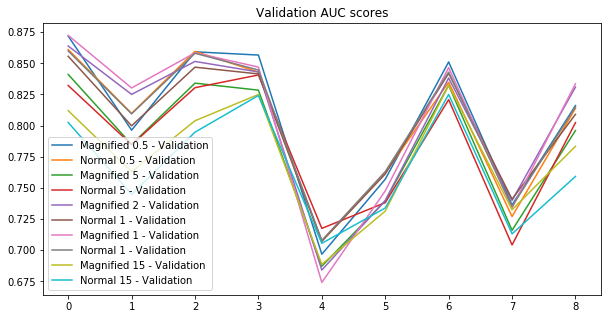

In [51]:
plt.figure(figsize=(10,5))
plt.plot(AUC_valid_magnif05,label='Magnified 0.5 - Validation')
plt.plot(AUC_valid_normal05,label='Normal 0.5 - Validation')
plt.plot(AUC_valid_magnif5,label='Magnified 5 - Validation')
plt.plot(AUC_valid_normal5,label='Normal 5 - Validation')
plt.plot(AUC_valid_magnif2,label='Magnified 2 - Validation')
plt.plot(AUC_valid_normal2,label='Normal 1 - Validation')
plt.plot(AUC_valid_magnif1,label='Magnified 1 - Validation')
plt.plot(AUC_valid_normal1,label='Normal 1 - Validation')
# plt.plot(AUC_valid_magnif01,label='Magnified 0.1 - Validation')
# plt.plot(AUC_valid_normal01,label='Normal 0.1 - Validation')
plt.plot(AUC_valid_magnif15,label='Magnified 15 - Validation')
plt.plot(AUC_valid_normal15,lab0e
         .l='Normal 15 - Validation')
plt.title('Validation AUC scores')
plt.legend(); plt.show()

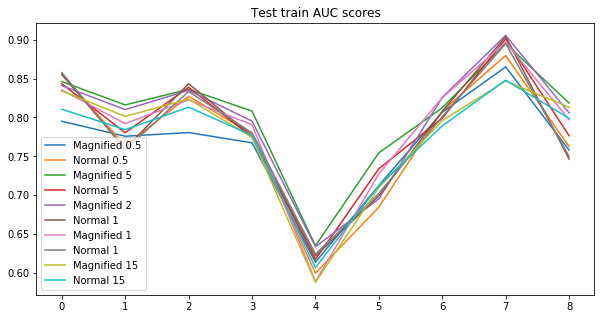

In [52]:
plt.figure(figsize=(10,5))
plt.plot(AUC_test_magnif05,label='Magnified 0.5')
plt.plot(AUC_test_normal05,label='Normal 0.5')
plt.plot(AUC_test_magnif5,label='Magnified 5')
plt.plot(AUC_test_normal5,label='Normal 5')
plt.plot(AUC_test_magnif2,label='Magnified 2')
plt.plot(AUC_test_normal2,label='Normal 1')
plt.plot(AUC_test_magnif1,label='Magnified 1')
plt.plot(AUC_test_normal1,label='Normal 1')
# plt.plot(AUC_test_magnif01,label='Magnified 0.1')
# plt.plot(AUC_test_normal01,label='Normal 0.1')
plt.plot(AUC_test_magnif15,label='Magnified 15')
plt.plot(AUC_test_normal15,label='Normal 15')
plt.title('Test train AUC scores')
plt.legend(); plt.show()

In [53]:
np.mean(AUC_test_magnif5)

0.8024181554668517

## SVC RBF

#### bin size 5

In [54]:
# with bin size 5
clf = SVC(class_weight='balanced', probability=True,kernel='rbf')
params = {'C':[0.05,0.1,0.5,1,5,10],'gamma':[0.001,0.01,0.1,0.5,1,5,10]}

In [55]:
clf_list_magnif5_rbf, grid_list, AUC_train_magnif5_rbf, AUC_valid_magnif5_rbf = try_clf(clf, params, spectrum_train_magnif5, targets_train)
AUC_test_magnif5_rbf = get_test_score(clf_list_magnif5_rbf, spectrum_test_train_magnif5, targets_test_train)

['OXACILINA']
The best parameters are:  {'C': 10, 'gamma': 0.5}
Train AUC:  0.9936  and validation AUC:  0.8592
['AMIKACINA']
The best parameters are:  {'C': 10, 'gamma': 0.5}
Train AUC:  0.9942  and validation AUC:  0.7921
['AMOXI/CLAV']
The best parameters are:  {'C': 10, 'gamma': 0.5}
Train AUC:  0.995  and validation AUC:  0.8523
['CIPROFLOXACINO']
The best parameters are:  {'C': 5, 'gamma': 0.5}
Train AUC:  0.9923  and validation AUC:  0.8268
['CLINDAMICINA']
The best parameters are:  {'C': 5, 'gamma': 0.1}
Train AUC:  0.8887  and validation AUC:  0.6978
['ERITROMICINA']
The best parameters are:  {'C': 5, 'gamma': 0.5}
Train AUC:  0.9908  and validation AUC:  0.7324
['LEVOFLOXACINO']
The best parameters are:  {'C': 10, 'gamma': 0.1}
Train AUC:  0.9607  and validation AUC:  0.8426
['PENICILINA']
The best parameters are:  {'C': 5, 'gamma': 1}
Train AUC:  1.0  and validation AUC:  0.7281
['TOBRAMICINA']
The best parameters are:  {'C': 10, 'gamma': 0.5}
Train AUC:  0.9969  and validat

In [56]:
clf_list_normal5_rbf, grid_list, AUC_train_normal5_rbf, AUC_valid_normal5_rbf = try_clf(clf, params, spectrum_train_normal5, targets_train)
AUC_test_normal5_rbf = get_test_score(clf_list_normal5_rbf, spectrum_test_train_normal5, targets_test_train)

['OXACILINA']
The best parameters are:  {'C': 10, 'gamma': 0.5}
Train AUC:  0.9878  and validation AUC:  0.8471
['AMIKACINA']
The best parameters are:  {'C': 10, 'gamma': 0.5}
Train AUC:  0.9921  and validation AUC:  0.7855
['AMOXI/CLAV']
The best parameters are:  {'C': 10, 'gamma': 0.5}
Train AUC:  0.9875  and validation AUC:  0.8422
['CIPROFLOXACINO']
The best parameters are:  {'C': 10, 'gamma': 0.1}
Train AUC:  0.926  and validation AUC:  0.8349
['CLINDAMICINA']
The best parameters are:  {'C': 5, 'gamma': 0.1}
Train AUC:  0.8569  and validation AUC:  0.714
['ERITROMICINA']
The best parameters are:  {'C': 5, 'gamma': 1}
Train AUC:  0.995  and validation AUC:  0.7284
['LEVOFLOXACINO']
The best parameters are:  {'C': 5, 'gamma': 1}
Train AUC:  0.9982  and validation AUC:  0.8419
['PENICILINA']
The best parameters are:  {'C': 5, 'gamma': 5}
Train AUC:  1.0  and validation AUC:  0.746
['TOBRAMICINA']
The best parameters are:  {'C': 10, 'gamma': 0.5}
Train AUC:  0.9921  and validation AUC

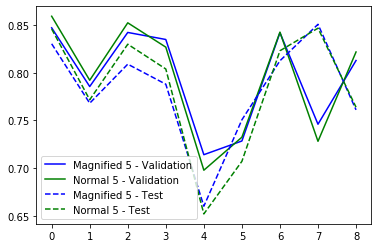

In [58]:
plt.plot(AUC_valid_normal5_rbf,'b',label='Magnified 5 - Validation')
plt.plot(AUC_valid_magnif5_rbf,'g',label='Normal 5 - Validation')
plt.plot(AUC_test_normal5_rbf,'b--',label='Magnified 5 - Test')
plt.plot(AUC_test_magnif5_rbf,'g--',label='Normal 5 - Test')
plt.legend(); plt.show()

#### bin size 1

In [59]:
clf_list_magnif1_rbf, grid_list, AUC_train_magnif1_rbf, AUC_valid_magnif1_rbf = try_clf(clf, params, spectrum_train_magnif1, targets_train)
AUC_test_magnif1_rbf = get_test_score(clf_list_magnif1_rbf, spectrum_test_train_magnif1, targets_test_train)

['OXACILINA']
The best parameters are:  {'C': 10, 'gamma': 0.1}
Train AUC:  0.9912  and validation AUC:  0.8599
['AMIKACINA']
The best parameters are:  {'C': 10, 'gamma': 0.1}
Train AUC:  0.9953  and validation AUC:  0.8198
['AMOXI/CLAV']
The best parameters are:  {'C': 10, 'gamma': 0.1}
Train AUC:  0.9909  and validation AUC:  0.8573
['CIPROFLOXACINO']
The best parameters are:  {'C': 5, 'gamma': 0.1}
Train AUC:  0.9884  and validation AUC:  0.8453
['CLINDAMICINA']
The best parameters are:  {'C': 10, 'gamma': 0.01}
Train AUC:  0.8527  and validation AUC:  0.6836
['ERITROMICINA']
The best parameters are:  {'C': 10, 'gamma': 0.1}
Train AUC:  0.9944  and validation AUC:  0.73
['LEVOFLOXACINO']
The best parameters are:  {'C': 5, 'gamma': 0.1}
Train AUC:  0.9948  and validation AUC:  0.862
['PENICILINA']
The best parameters are:  {'C': 5, 'gamma': 1}
Train AUC:  1.0  and validation AUC:  0.7232
['TOBRAMICINA']
The best parameters are:  {'C': 10, 'gamma': 0.1}
Train AUC:  0.9963  and validat

In [63]:
def save_clf(savepath,filename,clf_list):
  # filename must be without extension
  if (savepath[-1] != '/'): savepath = savepath + '/'
  with open(savepath+filename+'.data','wb') as filehandle:
    pickle.dump(clf_list,filehandle)

def load_clf(savepath,filename):
  if (savepath[-1] != '/'): savepath = savepath + '/'
  if os.path.isfile(savepath+filename+'.data'):
    with open(savepath+filename+'.data','rb') as filehandle:
      new_list = pickle.load(filehandle)
    print('Loaded!')
  else:
    print('File not found')
    new_list = []
  return new_list

In [65]:
savepath = path + 'Kaggle classifiers'
save_clf(savepath, 'magnif1_rbf',clf_list_magnif1_rbf)

In [60]:
clf_list_normal1_rbf, grid_list, AUC_train_normal1_rbf, AUC_valid_normal1_rbf = try_clf(clf, params, spectrum_train_normal1, targets_train)
AUC_test_normal1_rbf = get_test_score(clf_list_normal1_rbf, spectrum_test_train_normal1, targets_test_train)

['OXACILINA']


KeyboardInterrupt: 

In [ ]:
plt.plot(AUC_valid_normal1_rbf,'b',label='Magnified 1 - Validation')
plt.plot(AUC_valid_magnif1_rbf,'g',label='Normal 1 - Validation')
plt.plot(AUC_test_normal1_rbf,'b--',label='Magnified 1 - Test')
plt.plot(AUC_test_magnif1_rbf,'g--',label='Normal 1 - Test')
plt.legend(); plt.show()

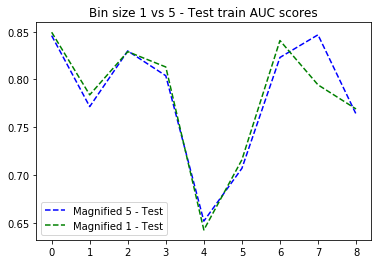

In [62]:
# plt.plot(AUC_valid_magnif5_rbf,'b',label='Magnified 5 - Valid')
plt.plot(AUC_test_magnif5_rbf,'b--',label='Magnified 5 - Test')
# plt.plot(AUC_valid_magnif1_rbf,'g',label='Magnified 1 - Valid')
plt.plot(AUC_test_magnif1_rbf,'g--',label='Magnified 1 - Test')
plt.title('Bin size 1 vs 5 - Test train AUC scores')
plt.legend(); plt.show()

# Save these marvelous models

In [ ]:
def save_clf(savepath,filename,clf_list):
  # filename must be without extension
  if (savepath[-1] != '/'): savepath = savepath + '/'
  with open(savepath+filename+'.data','wb') as filehandle:
    pickle.dump(clf_list,filehandle)

def load_clf(savepath,filename):
  if (savepath[-1] != '/'): savepath = savepath + '/'
  if os.path.isfile(savepath+filename+'.data'):
    with open(savepath+filename+'.data','rb') as filehandle:
      new_list = pickle.load(filehandle)
    print('Loaded!')
  else:
    print('File not found')
    new_list = []
  return new_list

In [ ]:
save_clf(savepath,'clf_list_magnif5_rbf',clf_list_magnif5_rbf)